<a href="https://colab.research.google.com/github/roshan457kumar/Dimensionality-Reduction-Using-K-Means-for-Activity-Recognition/blob/main/Dimensionality_Reduction_using_K_Means_for_Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
import zipfile
import io
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import time

# Function to download and load dataset
def load_data():
    page_url = 'https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones'
    page_response = requests.get(page_url)
    if page_response.status_code == 200:
        soup = BeautifulSoup(page_response.content, 'html.parser')
        download_link = soup.select_one('a[href$=".zip"]')['href']
        full_download_url = 'https://archive.ics.uci.edu' + download_link
        response = requests.get(full_download_url)
        if response.status_code == 200:
            with zipfile.ZipFile(io.BytesIO(response.content)) as outer_zip:
                inner_zip_name = 'UCI HAR Dataset.zip'
                with outer_zip.open(inner_zip_name) as inner_zip_file:
                    with zipfile.ZipFile(io.BytesIO(inner_zip_file.read())) as inner_zip:
                        with inner_zip.open('UCI HAR Dataset/train/X_train.txt') as myfile:
                            df = pd.read_csv(myfile, delim_whitespace=True, header=None)
                        with inner_zip.open('UCI HAR Dataset/train/y_train.txt') as myfile_y:
                            y = pd.read_csv(myfile_y, delim_whitespace=True, header=None)
    else:
        raise Exception("Failed to download or parse the dataset.")
    return df, y

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import numpy as np
import time

# Load dataset
df, y = load_data()

#TASK 1 - DO EDA and understand a little about the data.
#Only important thing is to know that it has a lot of features that don't make sense, just a
#bunch of readings from sensors.
#We think many of these features are redundant or irrelevant, and we want to find good features.


<ipython-input-1-836ccc4d8ebc>:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(myfile, delim_whitespace=True, header=None)
<ipython-input-1-836ccc4d8ebc>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y = pd.read_csv(myfile_y, delim_whitespace=True, header=None)


In [ ]:
print(df.info())
print(df.describe())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, 0 to 560
dtypes: float64(561)
memory usage: 31.5 MB
None
               0            1            2            3            4    \
count  7352.000000  7352.000000  7352.000000  7352.000000  7352.000000   
mean      0.274488    -0.017695    -0.109141    -0.605438    -0.510938   
std       0.070261     0.040811     0.056635     0.448734     0.502645   
min      -1.000000    -1.000000    -1.000000    -1.000000    -0.999873   
25%       0.262975    -0.024863    -0.120993    -0.992754    -0.978129   
50%       0.277193    -0.017219    -0.108676    -0.946196    -0.851897   
75%       0.288461    -0.010783    -0.097794    -0.242813    -0.034231   
max       1.000000     1.000000     1.000000     1.000000     0.916238   

               5            6            7            8            9    ...  \
count  7352.000000  7352.000000  7352.000000  7352.000000  7352.000000  ...   
mean     -0.604754    

In [ ]:
print(df.isnull().sum())

0      0
1      0
2      0
3      0
4      0
      ..
556    0
557    0
558    0
559    0
560    0
Length: 561, dtype: int64


In [ ]:
corr_matrix = df.corr()
redundant_features = corr_matrix[(corr_matrix > 0.9) | (corr_matrix < -0.9)]
print(redundant_features)

     0    1    2         3         4    5         6         7    8    \
0    1.0  NaN  NaN       NaN       NaN  NaN       NaN       NaN  NaN   
1    NaN  1.0  NaN       NaN       NaN  NaN       NaN       NaN  NaN   
2    NaN  NaN  1.0       NaN       NaN  NaN       NaN       NaN  NaN   
3    NaN  NaN  NaN  1.000000  0.927461  NaN  0.998632  0.920888  NaN   
4    NaN  NaN  NaN  0.927461  1.000000  NaN  0.922803  0.997347  NaN   
..   ...  ...  ...       ...       ...  ...       ...       ...  ...   
556  NaN  NaN  NaN       NaN       NaN  NaN       NaN       NaN  NaN   
557  NaN  NaN  NaN       NaN       NaN  NaN       NaN       NaN  NaN   
558  NaN  NaN  NaN       NaN       NaN  NaN       NaN       NaN  NaN   
559  NaN  NaN  NaN       NaN       NaN  NaN       NaN       NaN  NaN   
560  NaN  NaN  NaN       NaN       NaN  NaN       NaN       NaN  NaN   

          9    ...  551  552  553  554  555  556  557  558  559  560  
0         NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN 

In [ ]:
y = y.squeeze()

In [ ]:
for col in df.columns:
    print(f"{col} vs Target:")
    print(df[col].groupby(y).mean())

Streaming output truncated to the last 5000 lines.
3   -0.168368
4   -0.939274
5   -0.942360
6   -0.941635
Name: 5, dtype: float64
6 vs Target:
0
1   -0.350317
2   -0.279919
3    0.073157
4   -0.985281
5   -0.987893
6   -0.961890
Name: 6, dtype: float64
7 vs Target:
0
1   -0.054420
2   -0.017106
3    0.023240
4   -0.936243
5   -0.937355
6   -0.937975
Name: 7, dtype: float64
8 vs Target:
0
1   -0.249564
2   -0.132670
3   -0.190944
4   -0.936903
5   -0.940217
6   -0.940378
Name: 8, dtype: float64
9 vs Target:
0
1   -0.105249
2   -0.010971
3    0.442294
4   -0.926620
5   -0.922753
6   -0.910430
Name: 9, dtype: float64
10 vs Target:
0
1   -0.055544
2   -0.031982
3    0.026636
4   -0.531310
5   -0.533290
6   -0.538645
Name: 10, dtype: float64
11 vs Target:
0
1   -0.302737
2   -0.260591
3   -0.250321
4   -0.786459
5   -0.787666
6   -0.785164
Name: 11, dtype: float64
12 vs Target:
0
1    0.232027
2    0.194442
3    0.007864
4    0.831554
5    0.833057
6    0.806176
Name: 12, dtype: float64
13

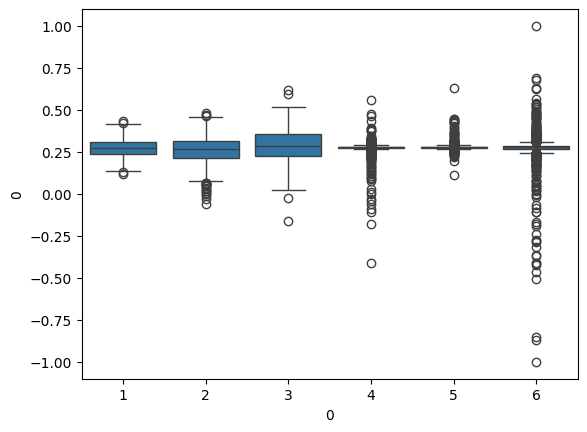

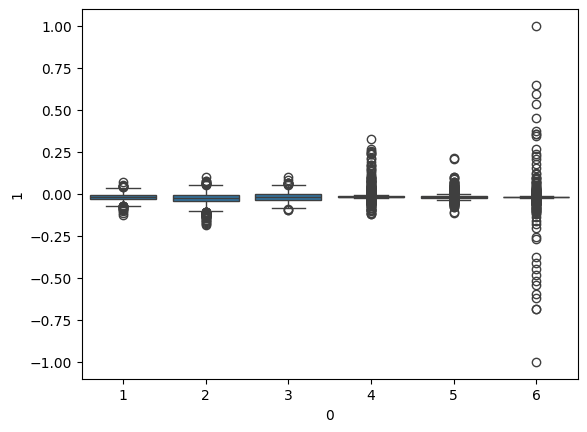

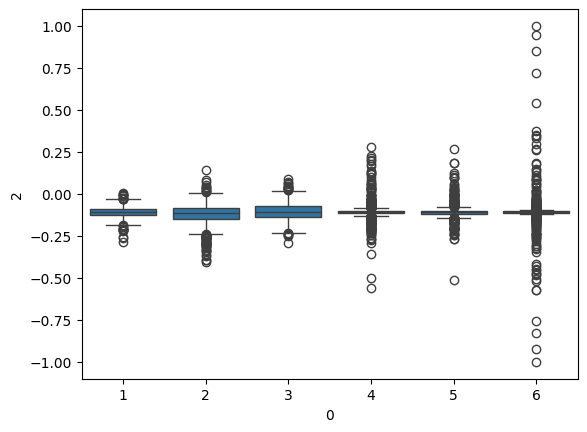

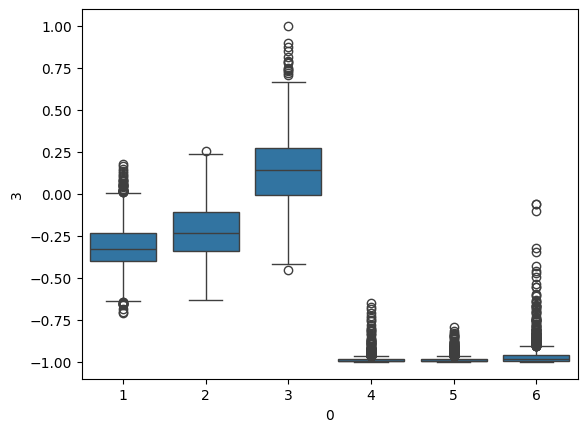

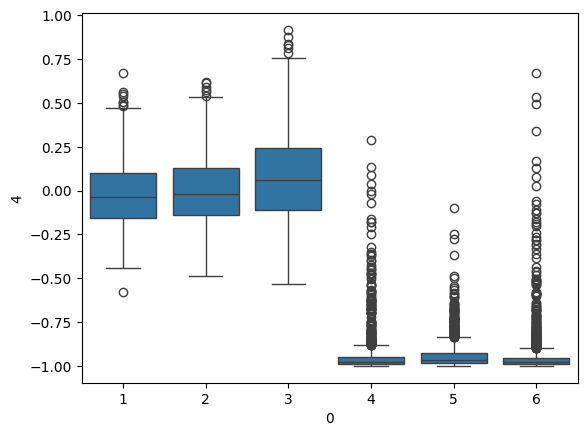

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in df.columns[:5]:  # Limit for visualization clarity
    sns.boxplot(data=df, x=y, y=df[col])
    plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)
print("Encoded labels:", np.unique(encoded_y))

Encoded labels: [0 1 2 3 4 5]


In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
print(df_scaled.head())

        0         1         2         3         4         5         6    \
0  0.200642 -0.063683 -0.419628 -0.868814 -0.939441 -0.737529 -0.859817   
1  0.055948  0.031486 -0.253908 -0.875426 -0.923902 -0.849304 -0.868531   
2  0.073515 -0.043416 -0.076295 -0.869039 -0.907760 -0.893785 -0.863137   
3  0.066696 -0.208422 -0.249712 -0.870626 -0.940022 -0.921805 -0.864503   
4  0.030469  0.027587 -0.109848 -0.875188 -0.934878 -0.921343 -0.867384   

        7         8         9    ...       551       552       553       554  \
0 -0.939019 -0.766437 -0.856036  ... -0.795359  0.025960 -0.276399 -0.360603   
1 -0.921998 -0.848928 -0.871359  ...  0.130614 -0.897357 -0.767990  0.133011   
2 -0.898854 -0.896701 -0.863323  ...  1.152336 -0.260878 -0.438316 -0.377840   
3 -0.938124 -0.925279 -0.863323  ...  1.112769  0.591045  0.463155 -0.135025   
4 -0.931789 -0.928028 -0.870260  ... -0.149577 -0.138515 -0.240313  0.340406   

        555       556       557       558       559       560  
0  0

In [14]:
from sklearn.model_selection import train_test_split
X_train_full, X_test_full, y_train, y_test = train_test_split(
    df_scaled, encoded_y, test_size=0.2, random_state=42, stratify=encoded_y
)
print("X_train_full shape:", X_train_full.shape)
print("X_test_full shape:", X_test_full.shape)
print("y_train shape:", len(y_train))
print("y_test shape:", len(y_test))


X_train_full shape: (5881, 561)
X_test_full shape: (1471, 561)
y_train shape: 5881
y_test shape: 1471


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
pipeline = Pipeline([
    ('model', GaussianNB())
])
pipeline.fit(X_train_full, y_train)
y_pred = pipeline.predict(X_test_full)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:", accuracy)


Accuracy score: 0.7586675730795377


In [16]:
import time
start_time = time.time()
pipeline = Pipeline([
    ('model', GaussianNB())
])
pipeline.fit(X_train_full, y_train)
y_pred = pipeline.predict(X_test_full)
end_time = time.time()
time_taken = end_time - start_time
print("Time taken for training and inference:", time_taken, "seconds")


Time taken for training and inference: 0.0924839973449707 seconds


In [18]:
from sklearn.cluster import KMeans
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(df_scaled.T)
selected_features_indices = np.argmin(kmeans.transform(df_scaled.T), axis=0)
selected_features = df.columns[selected_features_indices]
print("Selected features:", selected_features)

Selected features: Index([208, 280, 558, 12, 232, 209, 45, 164, 56, 298], dtype='int64')


In [19]:
X_selected = df_scaled.iloc[:, selected_features_indices]
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    X_selected, encoded_y, test_size=0.2, random_state=42, stratify=encoded_y
)
start_time = time.time()
pipeline_selected = Pipeline([
    ('model', GaussianNB())
])
pipeline_selected.fit(X_train_selected, y_train)
y_pred_selected = pipeline_selected.predict(X_test_selected)
end_time = time.time()
time_taken = end_time - start_time
print("Time taken for training and inference (selected features):", time_taken, "seconds")
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print("Accuracy score (selected features):", accuracy_selected)


Time taken for training and inference (selected features): 0.009879589080810547 seconds
Accuracy score (selected features): 0.7933378653976887
